## Homework1_Luyao Wang

In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib.patches as patches
from scipy import interp
import sklearn

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
df = pd.read_csv("KaggleV2-May-2016.csv")
df.head(10)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No
5,9.598513e+13,5626772,F,2016-04-27T08:36:51Z,2016-04-29T00:00:00Z,76,REPÚBLICA,0,1,0,0,0,0,No
6,7.336882e+14,5630279,F,2016-04-27T15:05:12Z,2016-04-29T00:00:00Z,23,GOIABEIRAS,0,0,0,0,0,0,Yes
7,3.449833e+12,5630575,F,2016-04-27T15:39:58Z,2016-04-29T00:00:00Z,39,GOIABEIRAS,0,0,0,0,0,0,Yes
8,5.639473e+13,5638447,F,2016-04-29T08:02:16Z,2016-04-29T00:00:00Z,21,ANDORINHAS,0,0,0,0,0,0,No
9,7.812456e+13,5629123,F,2016-04-27T12:48:25Z,2016-04-29T00:00:00Z,19,CONQUISTA,0,0,0,0,0,0,No


In [3]:
print("The shape of the DataFrame is: {}".format(df.shape))

The shape of the DataFrame is: (110527, 14)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [5]:
df.duplicated().sum()

0

From the information above we can tell there are no missing values in any column and we do not have duplicated data.
Next, we would fix some inconsistancies in the dataset and correct some typos in the titles.

In [6]:
df.rename(columns = {'Hipertension': 'Hypertension', 'Handcap': 'Handicap', 'SMS_received': 'SMSReceived', 'No-show': 'NoShow'}, inplace = True)
print(df.columns)

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hypertension',
       'Diabetes', 'Alcoholism', 'Handicap', 'SMSReceived', 'NoShow'],
      dtype='object')


In [7]:
df['PatientId'] = df['PatientId'].astype('int64')
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay']).dt.date.astype('datetime64[ns]')
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay']).dt.date.astype('datetime64[ns]')
df.dtypes

PatientId                  int64
AppointmentID              int64
Gender                    object
ScheduledDay      datetime64[ns]
AppointmentDay    datetime64[ns]
Age                        int64
Neighbourhood             object
Scholarship                int64
Hypertension               int64
Diabetes                   int64
Alcoholism                 int64
Handicap                   int64
SMSReceived                int64
NoShow                    object
dtype: object

We drop PatientId and AppointmentID since they are not useful data for our model

In [8]:
df.drop(['PatientId', 'AppointmentID'], axis=1, inplace=True)

In [9]:
df.head()

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow
0,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [10]:
print("Unique Values of Age: {}".format(np.sort(df.Age.unique())))

Unique Values of Age: [ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 102 115]


In [11]:
print("The number of patients with the age less than -1: {}".format(df[df.Age == -1].shape[0]))

The number of patients with the age less than -1: 1


There is only one patient data with the age of -1, therefore we drop it considering it as a error

In [12]:
df = df[df.Age >= 0]

From our instint, we might think that the longer the wait time, the more possibility the patients skip their appointment
Therefore, we would like to create a new feature which is WaitingTime. It dipicts how many days the patient waited before the appointment date.
We need to check for whether there are possible errors such that scheduledDay actually comes after the appointmentDay.

In [13]:
df['AppointmentDay'] = np.where((df['AppointmentDay'] - df['ScheduledDay']).dt.days < 0, df['ScheduledDay'], df['AppointmentDay'])

In [14]:
df['WaitingTime'] = df['AppointmentDay'] - df['ScheduledDay']
df['WaitingTime'] = df['WaitingTime'].dt.days

We double check in order to make sure there are no error data (wating days less than 0).

In [15]:
print("There are '{}' cases where the Waiting days are less than 0.".format(df[df.WaitingTime < 0].shape[0]))

There are '0' cases where the Waiting days are less than 0.


In [16]:
df.sample(n = 5)

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow,WaitingTime
59802,F,2016-04-27,2016-05-10,85,MONTE BELO,0,0,0,0,0,0,No,13
96172,M,2016-06-06,2016-06-06,69,JARDIM DA PENHA,0,0,0,0,0,0,No,0
92304,F,2016-06-03,2016-06-03,34,DA PENHA,0,0,0,0,1,0,No,0
54863,M,2016-05-04,2016-05-11,67,ILHA DO PRÍNCIPE,0,0,0,0,0,1,Yes,7
2441,F,2016-04-29,2016-04-29,3,SANTO ANTÔNIO,0,0,0,0,0,0,Yes,0


# Data Visualization

## 1. General ratio on Show or NoShow 

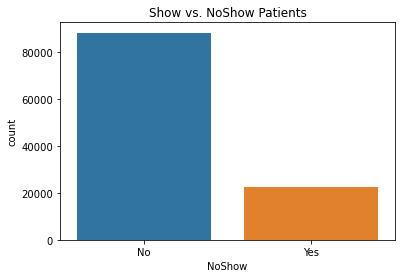

In [17]:
#sns.set_style("whitegrid")
ax = sns.countplot(x=df.NoShow, data=df)
ax.set_title("Show vs. NoShow Patients")
plt.show()

We can see from the above graph that from 110526 patients, around 88000 patients did show up to the appointment.
The general rate of showing up to an appointment is around 79.6%
The general rate of not showing up to an appointment is around 20.4%

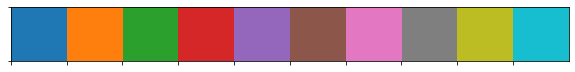

In [18]:
sns.palplot(sns.color_palette("tab10"))

## 2. Gender distribution with Show/NoShow for each group

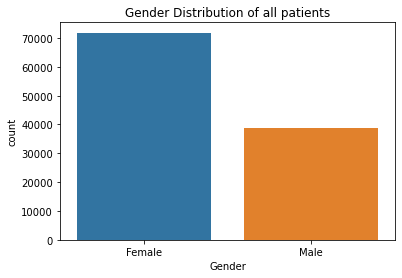

In [19]:
ax = sns.countplot(x=df.Gender, data=df)
ax.set_title("Gender Distribution of all patients")
x_ticks_labels=['Female', 'Male']
ax.set_xticklabels(x_ticks_labels)
plt.show()

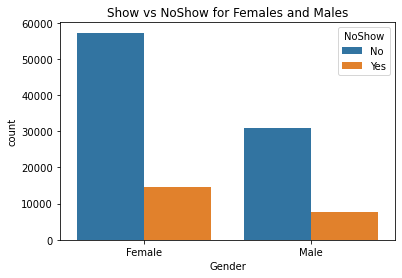

In [20]:
ax = sns.countplot(data=df, x=df.Gender, hue=df.NoShow)
ax.set_title("Show vs NoShow for Females and Males")
x_ticks_labels=['Female', 'Male']
ax.set_xticklabels(x_ticks_labels)
plt.show()

As shown above, around 71000 patients are female and 39526 patients are male.
Around 64% patients are female and 36% are male.
In female group, around 21% female patients did not show up, and around 20% of male patients did not show up.

## 3. Age distribution 

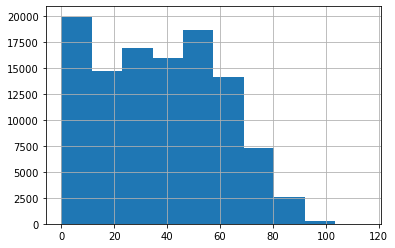

In [21]:
df['Age'].hist(bins=10);

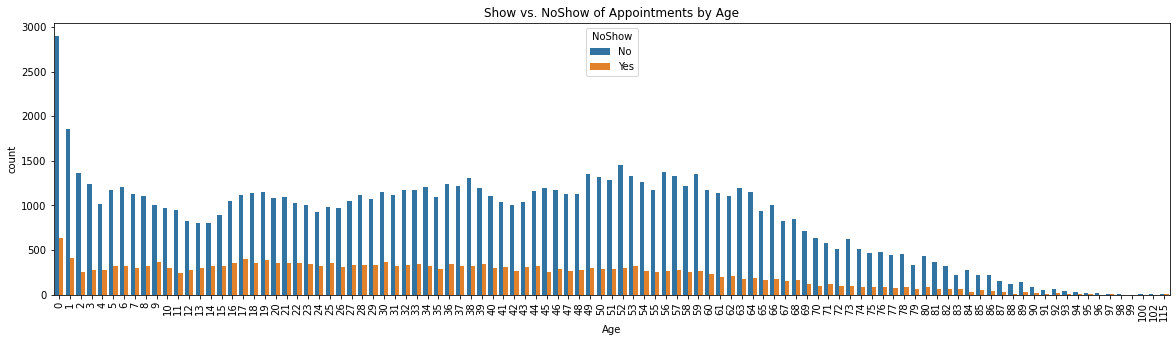

In [22]:
plt.figure(figsize=(20, 5))
ax = sns.countplot(x=df.Age, hue=df.NoShow)
plt.xticks(rotation=90);
ax.set_title("Show vs. NoShow of Appointments by Age")
plt.show()

From the above figure, we can tell that the rate of showing up at their appointments are very similar except for patient with age 0 and 1.

## 4. Neighbourhood

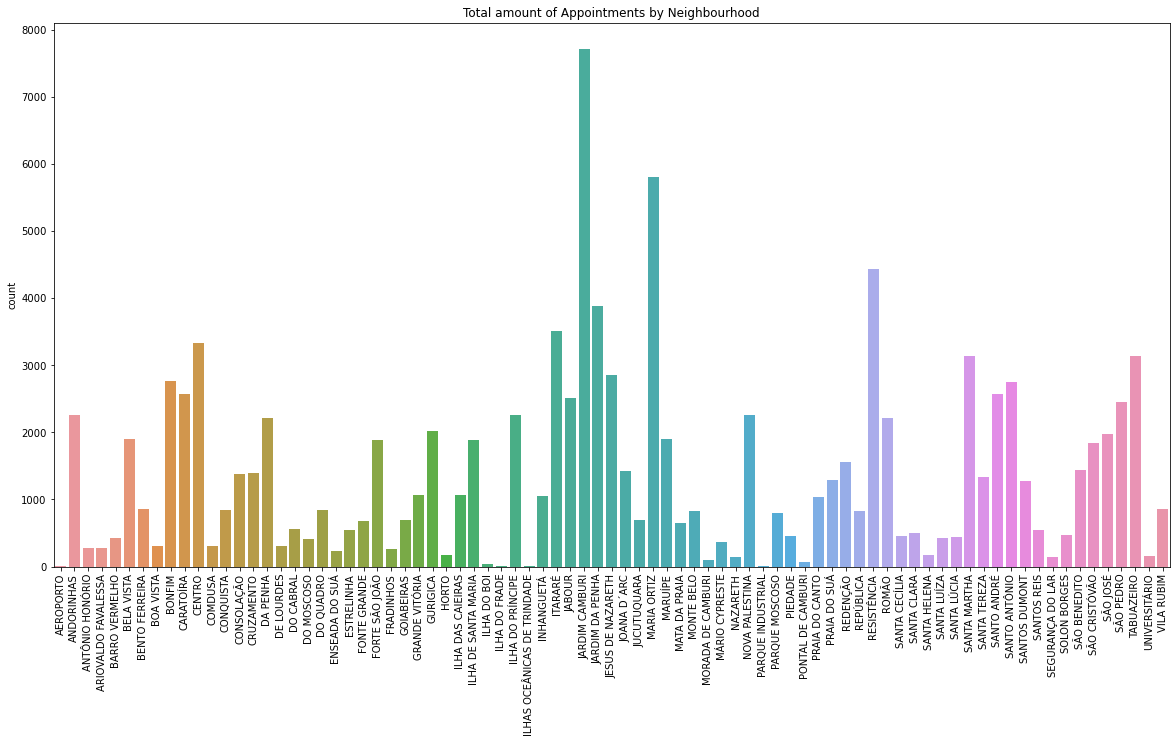

In [23]:
plt.figure(figsize=(20, 10))
ax = sns.countplot(x=np.sort(df.Neighbourhood))
ax.set_title("Total amount of Appointments by Neighbourhood")
plt.xticks(rotation=90)
plt.show()

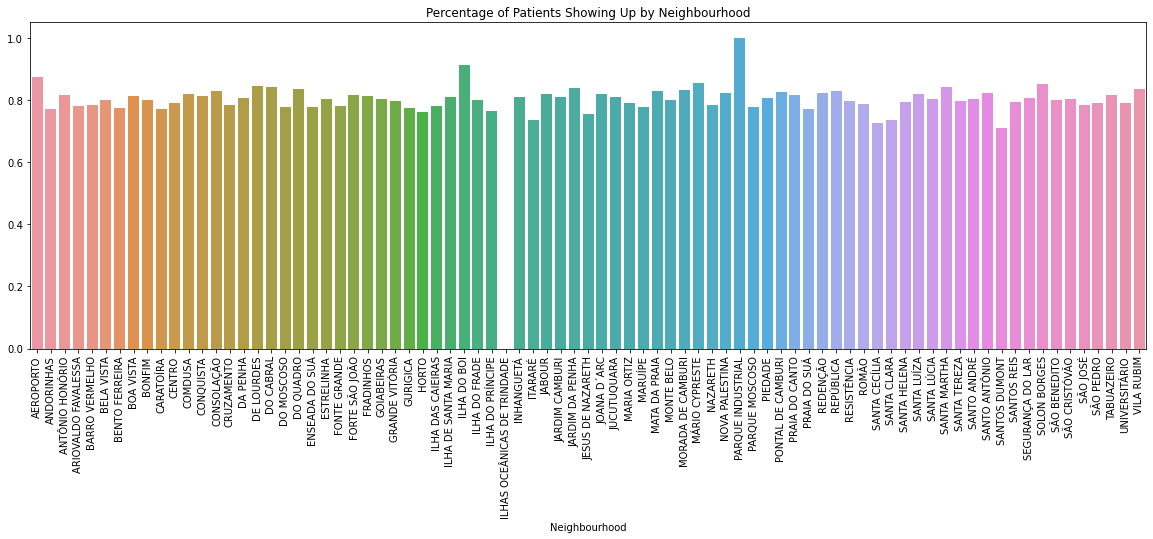

In [24]:
df_Neighbourhood_ratio = df[df.NoShow == 'No'].groupby(['Neighbourhood']).size()/df.groupby(['Neighbourhood']).size()

plt.figure(figsize=(20, 6))
ax = sns.barplot(x=df_Neighbourhood_ratio.index, y=df_Neighbourhood_ratio)
ax.set_title("Percentage of Patients Showing Up by Neighbourhood")
plt.xticks(rotation=90)
plt.show()

From the above figure, we can see that there are large differences between the number of appointments made in each neighbourhood. However, the percentage of actually attedning the appointment is almost the same: around 80%. The only one neighbourhood reaching 100% attendance is becuase there were no appointment booked in this neighbourhood which means 0 NoShow rate.

## 5. Scholarship

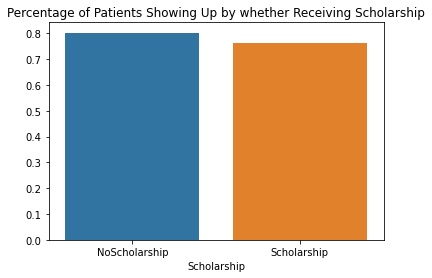

In [25]:
df_Scholarship_ratio = df[df.NoShow == 'No'].groupby(['Scholarship']).size()/df.groupby(['Scholarship']).size()
ax = sns.barplot(x=df_Scholarship_ratio.index, y=df_Scholarship_ratio)
ax.set_title("Percentage of Patients Showing Up by whether Receiving Scholarship")
x_ticks_labels=['NoScholarship', 'Scholarship']
ax.set_xticklabels(x_ticks_labels)
plt.show()

From the graph we can tell that the difference of the rate of showing up to their appointments are not substantial.

## 6. Hypertension

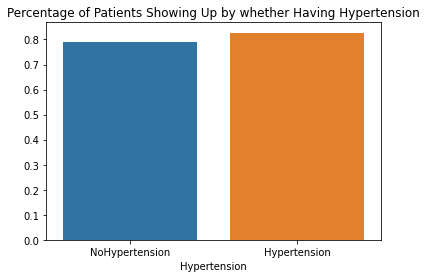

In [26]:
df_Hypertension_ratio = df[df.NoShow == 'No'].groupby(['Hypertension']).size()/df.groupby(['Hypertension']).size()
ax = sns.barplot(x=df_Hypertension_ratio.index, y=df_Hypertension_ratio)
ax.set_title("Percentage of Patients Showing Up by whether Having Hypertension")
x_ticks_labels=['NoHypertension', 'Hypertension']
ax.set_xticklabels(x_ticks_labels)
plt.show()

The figure clearly shows that there no big difference between the rate of patients with or without Hypertnstion showing up.

## 7. Diabetes

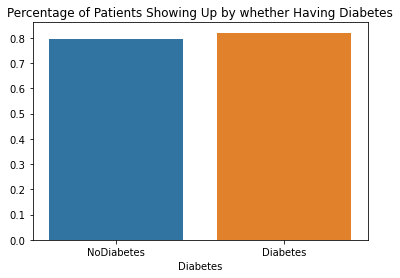

In [27]:
df_Diabetes_ratio = df[df.NoShow == 'No'].groupby(['Diabetes']).size()/df.groupby(['Diabetes']).size()
ax = sns.barplot(x=df_Diabetes_ratio.index, y=df_Diabetes_ratio)
ax.set_title("Percentage of Patients Showing Up by whether Having Diabetes")
x_ticks_labels=['NoDiabetes', 'Diabetes']
ax.set_xticklabels(x_ticks_labels)
plt.show()

The figure clearly shows that there no big difference between the rate of patients with or without Diabetes showing up.

## 8. Alcoholism

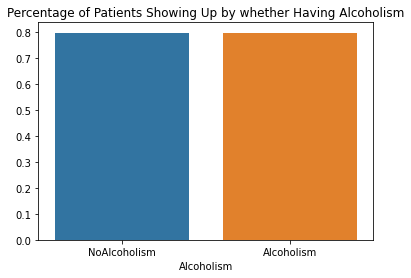

In [28]:
df_Alcoholism_ratio = df[df.NoShow == 'No'].groupby(['Alcoholism']).size()/df.groupby(['Alcoholism']).size()
ax = sns.barplot(x=df_Alcoholism_ratio.index, y=df_Alcoholism_ratio)
ax.set_title("Percentage of Patients Showing Up by whether Having Alcoholism")
x_ticks_labels=['NoAlcoholism', 'Alcoholism']
ax.set_xticklabels(x_ticks_labels)
plt.show()

The figure clearly shows that the rate of patients with or without Alcoholism showing up are almost the same.

## 9. Handicap

In [29]:
print("Unique Values of Handicap: {}".format(np.sort(df.Handicap.unique())))

Unique Values of Handicap: [0 1 2 3 4]


In [30]:
print("The number of patients with Handicap Level 0: {}".format(df[df.Handicap == 0].shape[0]))
print("The number of patients with Handicap Level 1: {}".format(df[df.Handicap == 1].shape[0]))
print("The number of patients with Handicap Level 2: {}".format(df[df.Handicap == 2].shape[0]))
print("The number of patients with Handicap Level 3: {}".format(df[df.Handicap == 3].shape[0]))
print("The number of patients with Handicap Level 4: {}".format(df[df.Handicap == 4].shape[0]))

The number of patients with Handicap Level 0: 108285
The number of patients with Handicap Level 1: 2042
The number of patients with Handicap Level 2: 183
The number of patients with Handicap Level 3: 13
The number of patients with Handicap Level 4: 3


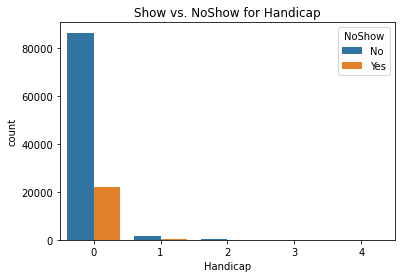

In [31]:
ax = sns.countplot(x=df.Handicap, hue=df.NoShow, data=df)
ax.set_title("Show vs. NoShow for Handicap")
plt.show()

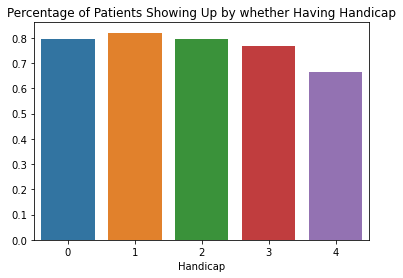

In [32]:
df_Handicap_ratio = df[df.NoShow == 'No'].groupby(['Handicap']).size()/df.groupby(['Handicap']).size()
ax = sns.barplot(x=df_Handicap_ratio.index, y=df_Handicap_ratio)
ax.set_title("Percentage of Patients Showing Up by whether Having Handicap")
plt.show()

We can see from the above graph that patients with different handicap level have different rate of showing up to their appointment.

## 10. SMSReceived

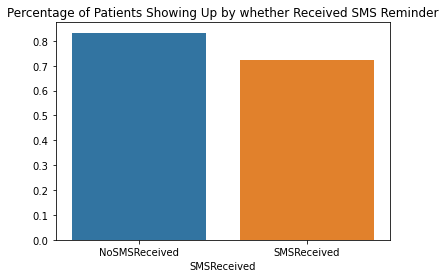

In [33]:
df_SMS_ratio = df[df.NoShow == 'No'].groupby(['SMSReceived']).size()/df.groupby(['SMSReceived']).size()
ax = sns.barplot(x=df_SMS_ratio.index, y=df_SMS_ratio)
ax.set_title("Percentage of Patients Showing Up by whether Received SMS Reminder")
x_ticks_labels=['NoSMSReceived', 'SMSReceived']
ax.set_xticklabels(x_ticks_labels)
plt.show()

We can tell from the above graph that patients who received SMS reminder have around 82% possibility showing up whereas patients who did not receieve SMS reminder with only have around 71% possibility showing up.

## 11. Waiting Days

In [34]:
print("Unique Values of WaitingTime: {}".format(np.sort(df.WaitingTime.unique())))

Unique Values of WaitingTime: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98 101 102 103 104 105 107 108 109 110
 111 112 115 117 119 122 123 125 126 127 132 133 139 142 146 151 155 162
 169 176 179]


In [35]:
print("The number of patients with the wait time = 123 are {}".format(df[df.WaitingTime == 123].shape[0]))
print("The number of patients with the wait time = 124 are {}".format(df[df.WaitingTime == 124].shape[0]))
print("The number of patients with the wait time = 125 are {}".format(df[df.WaitingTime == 125].shape[0]))

The number of patients with the wait time = 123 are 1
The number of patients with the wait time = 124 are 0
The number of patients with the wait time = 125 are 1


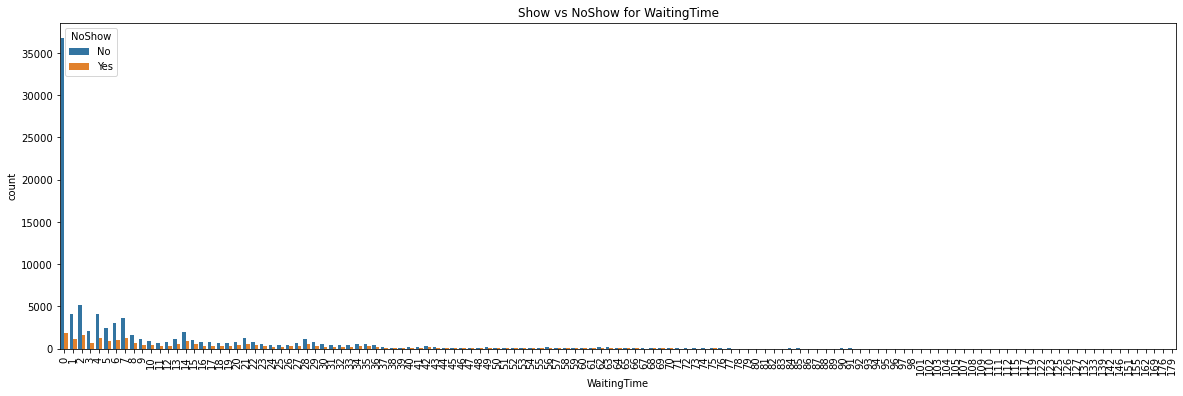

In [36]:
plt.figure(figsize=(20, 6))
ax = sns.countplot(data=df, x=df.WaitingTime, hue=df.NoShow)
ax.set_title("Show vs NoShow for WaitingTime")
plt.xticks(rotation=90)
plt.show()

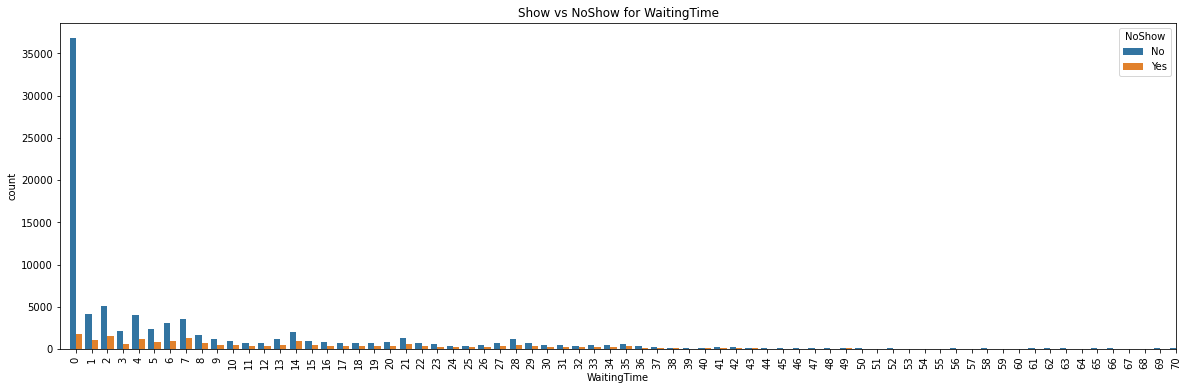

In [37]:
plt.figure(figsize=(20, 6))
ax = sns.countplot(data=df, x=df.WaitingTime, hue=df.NoShow)
ax.set_title("Show vs NoShow for WaitingTime")
plt.xticks(rotation=90)
ax.set(xlim = (-1, 70))
plt.show()

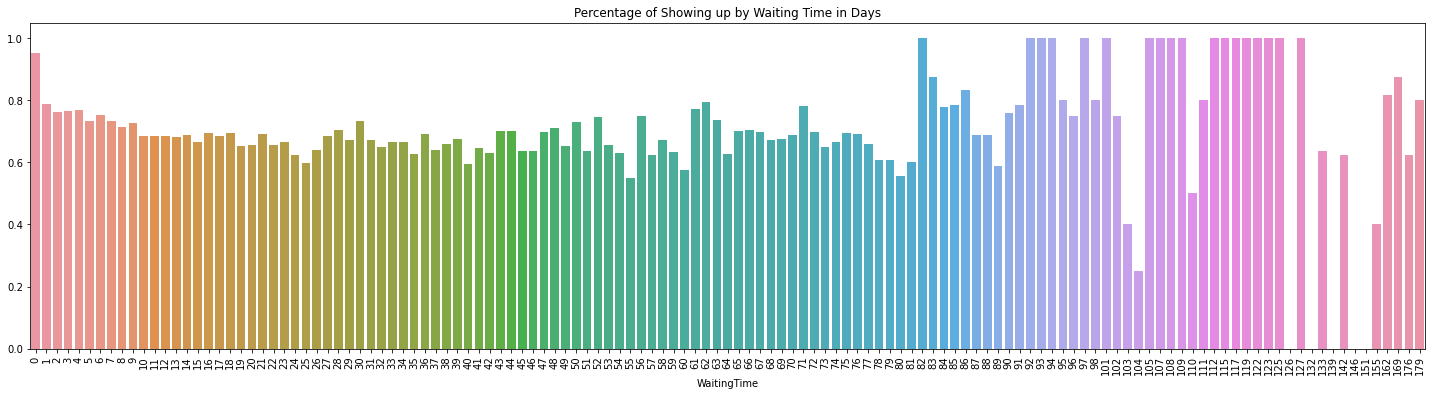

In [38]:
df_WaitingTime_ratio = df[df.NoShow == 'No'].groupby(['WaitingTime']).size()/df.groupby(['WaitingTime']).size()

plt.figure(figsize=(25,6))
ax = sns.barplot(x=df_WaitingTime_ratio.index, y=df_WaitingTime_ratio)
ax.set_title("Percentage of Showing up by Waiting Time in Days")
plt.xticks(rotation=90)
plt.show()

From the above graph we can see that the differences among the percent of patient showing up with various waiting time are significant. <br>
In general, The longer the waiting time in days, the more likely the patient skip their appointment. (The 100% present rate of some of the coloumn at the end of the figure is due to very few sample number. eg. there is only 1 patient with 125 waiting days and 0 patient with 124 waiting days.)

# 2. Model Building

## Data preprocessing before model building

In [39]:
df.sample(n=10)

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow,WaitingTime
56072,F,2016-04-29,2016-05-05,66,SÃO JOSÉ,0,1,0,0,0,1,No,6
29888,F,2016-04-27,2016-05-02,73,SANTA MARTHA,0,1,0,0,0,1,No,5
77314,F,2016-05-05,2016-05-20,46,SANTO ANTÔNIO,0,0,0,0,0,0,No,15
110353,M,2016-05-25,2016-06-08,11,RESISTÊNCIA,0,0,0,0,0,1,No,14
92710,F,2016-06-07,2016-06-07,31,JARDIM CAMBURI,0,0,0,0,0,0,No,0
68822,F,2016-05-20,2016-05-20,27,TABUAZEIRO,0,0,0,0,0,0,No,0
79629,F,2016-05-20,2016-05-20,32,SANTA HELENA,0,0,0,0,0,0,No,0
22810,M,2016-05-05,2016-05-19,84,ITARARÉ,0,1,0,0,0,0,No,14
109462,M,2016-06-01,2016-06-03,5,ITARARÉ,0,0,0,0,0,0,Yes,2
16327,F,2016-05-02,2016-05-16,4,TABUAZEIRO,1,0,0,0,0,0,Yes,14


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110526 entries, 0 to 110526
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Gender          110526 non-null  object        
 1   ScheduledDay    110526 non-null  datetime64[ns]
 2   AppointmentDay  110526 non-null  datetime64[ns]
 3   Age             110526 non-null  int64         
 4   Neighbourhood   110526 non-null  object        
 5   Scholarship     110526 non-null  int64         
 6   Hypertension    110526 non-null  int64         
 7   Diabetes        110526 non-null  int64         
 8   Alcoholism      110526 non-null  int64         
 9   Handicap        110526 non-null  int64         
 10  SMSReceived     110526 non-null  int64         
 11  NoShow          110526 non-null  object        
 12  WaitingTime     110526 non-null  int64         
dtypes: datetime64[ns](2), int64(8), object(3)
memory usage: 16.8+ MB


In [41]:
# Encode the input variables
le_Gender = LabelEncoder()
le_Age = LabelEncoder()
le_Neighbourhood = LabelEncoder()
le_Scholarship = LabelEncoder()
le_Hypertension = LabelEncoder()
le_Diabetes = LabelEncoder()
le_Alcoholism = LabelEncoder()
le_Handicap = LabelEncoder()
le_SMS = LabelEncoder()
le_WaitingTime = LabelEncoder()
le_NoShow = LabelEncoder()

In [42]:
df['Gender_n'] = le_Gender.fit_transform(df['Gender'])
df['Age_n'] = le_Age.fit_transform(df['Age'])
df['Neighbourhood_n'] = le_Neighbourhood.fit_transform(df['Neighbourhood'])
df['Scholarship_n'] = le_Scholarship.fit_transform(df['Scholarship'])
df['Hypertension_n'] = le_Hypertension.fit_transform(df['Hypertension'])
df['Diabetes_n'] = le_Diabetes.fit_transform(df['Diabetes'])
df['Alcoholism_n'] = le_Alcoholism.fit_transform(df['Alcoholism'])
df['Handicap_n'] = le_Handicap.fit_transform(df['Handicap'])
df['SMS'] = le_SMS.fit_transform(df['SMSReceived'])
df['WaitingTime_n'] = le_WaitingTime.fit_transform(df['WaitingTime'])
df['NoShow_n'] = le_NoShow.fit_transform(df['NoShow'])

In [43]:
df.head(n=10)

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,...,Age_n,Neighbourhood_n,Scholarship_n,Hypertension_n,Diabetes_n,Alcoholism_n,Handicap_n,SMS,WaitingTime_n,NoShow_n
0,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,...,62,39,0,1,0,0,0,0,0,0
1,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,...,56,39,0,0,0,0,0,0,0,0
2,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,...,62,45,0,0,0,0,0,0,0,0
3,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,...,8,54,0,0,0,0,0,0,0,0
4,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,...,56,39,0,1,1,0,0,0,0,0
5,F,2016-04-27,2016-04-29,76,REPÚBLICA,0,1,0,0,0,...,76,58,0,1,0,0,0,0,2,0
6,F,2016-04-27,2016-04-29,23,GOIABEIRAS,0,0,0,0,0,...,23,25,0,0,0,0,0,0,2,1
7,F,2016-04-27,2016-04-29,39,GOIABEIRAS,0,0,0,0,0,...,39,25,0,0,0,0,0,0,2,1
8,F,2016-04-29,2016-04-29,21,ANDORINHAS,0,0,0,0,0,...,21,1,0,0,0,0,0,0,0,0
9,F,2016-04-27,2016-04-29,19,CONQUISTA,0,0,0,0,0,...,19,12,0,0,0,0,0,0,2,0


In [1]:
df.info()

NameError: name 'df' is not defined

In [2]:
target_n = df.NoShow_n

NameError: name 'df' is not defined

In [45]:
target_n.head(n=10)

0    0
1    0
2    0
3    0
4    0
5    0
6    1
7    1
8    0
9    0
Name: NoShow_n, dtype: int32

In [46]:
input_n = df.drop(['NoShow', 'Gender', 'Age', 'Neighbourhood', 'Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism', 'Handicap', 'SMSReceived', 'WaitingTime', 'ScheduledDay', 'AppointmentDay', 'NoShow_n'], axis='columns')

In [60]:
input_n

,Gender_n,Age_n,Neighbourhood_n,Scholarship_n,Hypertension_n,Diabetes_n,Alcoholism_n,Handicap_n,SMS,WaitingTime_n
0,0,62,39,0,1,0,0,0,0,0
1,1,56,39,0,0,0,0,0,0,0
2,0,62,45,0,0,0,0,0,0,0
3,0,8,54,0,0,0,0,0,0,0
4,0,56,39,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
110522,0,56,43,0,0,0,0,0,1,35
110523,0,51,43,0,0,0,0,0,1,35
110524,0,21,43,0,0,0,0,0,1,41
110525,0,38,43,0,0,0,0,0,1,41


## 1. Decision TreeUse StratifiedKFold Cross Validation

We try out Random Forest Classifier here: (we use StratifiedKFold)

Below is the ROC curve, the average of Recall score, Precision score, F1 score, AUC score:

In [230]:
kfold = StratifiedKFold(n_splits=10)
m_rfc = RandomForestClassifier(n_estimators=50) 

tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1

recalls =[]
precisions =[]
f1scores =[]

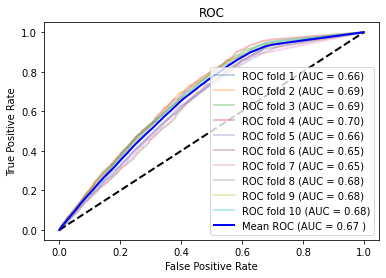

In [231]:
x  = input_n
y = target_n
for train,test in kfold.split(x,y):
    model = m_rfc.fit(x.iloc[train],y.iloc[train])
    pred_prob = model.predict_proba(x.iloc[test])
    pred = model.predict(x.iloc[test])

    #prediction = m_rfc.fit(x[train],y[train]).predict_proba(x[test])
    fpr, tpr, t = roc_curve(y.iloc[test], pred_prob[:, 1])
    recalls.append(recall_score(y.iloc[test], pred))
    precisions.append(precision_score(y.iloc[test], pred))
    f1scores.append(sklearn.metrics.f1_score(y.iloc[test], pred))
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = sklearn.metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = sklearn.metrics.auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [232]:
print(recalls)
print(np.mean(recalls))

[0.16666666666666666, 0.19444444444444445, 0.21818996415770608, 0.19041218637992832, 0.1953405017921147, 0.20116487455197132, 0.14343343792021515, 0.1814516129032258, 0.1689068100358423, 0.1742831541218638]
0.1834293652973978


In [233]:
print(precisions)
print(np.mean(precision))

[0.2995169082125604, 0.34609250398724084, 0.3349381017881706, 0.33810660302307083, 0.31142857142857144, 0.284717818642993, 0.2982292637465051, 0.32504012841091495, 0.3342198581560284, 0.3144704931285368]
0.3157894736842105


In [234]:
print(f1scores)
print(np.mean(f1scores))

[0.21416234887737481, 0.24899598393574293, 0.2642430819316332, 0.2436228145600459, 0.24008810572687223, 0.23575741664478864, 0.1937046004842615, 0.23289246693502014, 0.2244047619047619, 0.22427212453156528]
0.23221437055320662


In [235]:
print(aucs)
print(np.mean(aucs))

[0.6572979609590829, 0.6894452753875466, 0.6912362472821659, 0.696422759470618, 0.6552469384114724, 0.6478538050083318, 0.6482340057758138, 0.6794157492746202, 0.6840655960711644, 0.6835377654646089]
0.6732756103105425


## 2. Logistic Regression

we use StratifiedKFold for logistic regression:

Below is the ROC curve, the average of Recall score, Precision score, F1 score, AUC score:

In [237]:
kfold = StratifiedKFold(n_splits=10)
m_rfc = LogisticRegression() 

tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1

recalls =[]
precisions =[]
f1scores =[]

C:\Users\wendy\Download\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\wendy\Download\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

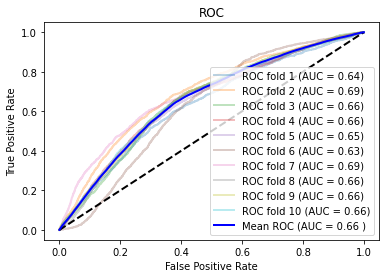

In [238]:
x  = input_n
y = target_n
for train,test in kfold.split(x,y):
    model = m_rfc.fit(x.iloc[train],y.iloc[train])
    pred_prob = model.predict_proba(x.iloc[test])
    pred = model.predict(x.iloc[test])

    #prediction = m_rfc.fit(x[train],y[train]).predict_proba(x[test])
    fpr, tpr, t = roc_curve(y.iloc[test], pred_prob[:, 1])
    recalls.append(recall_score(y.iloc[test], pred))
    precisions.append(precision_score(y.iloc[test], pred))
    f1scores.append(sklearn.metrics.f1_score(y.iloc[test], pred))
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = sklearn.metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = sklearn.metrics.auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [239]:
print(recalls)
print(np.mean(recalls))

[0.010304659498207885, 0.0035842293906810036, 0.017921146953405017, 0.0013440860215053765, 0.0076164874551971325, 0.016577060931899642, 0.05064993276557597, 0.016129032258064516, 0.02060931899641577, 0.01971326164874552]
0.016444921591969783


In [240]:
print(precisions)
print(np.mean(precision))

[0.3026315789473684, 0.34782608695652173, 0.37383177570093457, 0.42857142857142855, 0.2361111111111111, 0.07312252964426877, 0.5231481481481481, 0.26666666666666666, 0.5476190476190477, 0.42718446601941745]
0.3157894736842105


In [241]:
print(f1scores)
print(np.mean(f1scores))

[0.019930675909878685, 0.007095343680709535, 0.03420265070542967, 0.0026797677534613666, 0.014756944444444446, 0.027027027027027025, 0.09235798937474458, 0.030418250950570346, 0.039723661485319514, 0.037687366167023555]
0.030587967749860872


In [242]:
print(aucs)
print(np.mean(aucs))

[0.6351006060805532, 0.6922108023415936, 0.6572746986155148, 0.6581058448822235, 0.6527346053060898, 0.6280969137676098, 0.6902828459712014, 0.6562580767073855, 0.6630700428319476, 0.6627006223636409]
0.659583505886776


## 3. Naïve Bayes

We try out GaussianNB classifier here (we use StratifiedKFold):

Below is the ROC curve, the average of Recall score, Precision score, F1 score, AUC score:

In [243]:
kfold = StratifiedKFold(n_splits=10)
m_rfc = GaussianNB() 

tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1

recalls =[]
precisions =[]
f1scores =[]

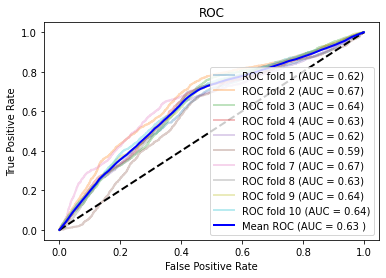

In [244]:
x  = input_n
y = target_n
for train,test in kfold.split(x,y):
    model = m_rfc.fit(x.iloc[train],y.iloc[train])
    pred_prob = model.predict_proba(x.iloc[test])
    pred = model.predict(x.iloc[test])

    #prediction = m_rfc.fit(x[train],y[train]).predict_proba(x[test])
    fpr, tpr, t = roc_curve(y.iloc[test], pred_prob[:, 1])
    recalls.append(recall_score(y.iloc[test], pred))
    precisions.append(precision_score(y.iloc[test], pred))
    f1scores.append(sklearn.metrics.f1_score(y.iloc[test], pred))
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = sklearn.metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = sklearn.metrics.auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [245]:
print(recalls)
print(np.mean(recalls))

[0.10797491039426524, 0.11469534050179211, 0.09991039426523297, 0.1003584229390681, 0.1057347670250896, 0.13620071684587814, 0.2138054683998207, 0.10752688172043011, 0.15681003584229392, 0.16756272401433692]
0.13105796619482077


In [246]:
print(precisions)
print(np.mean(precision))

[0.31752305665349145, 0.3861236802413273, 0.31320224719101125, 0.33185185185185184, 0.35703479576399394, 0.20212765957446807, 0.48673469387755103, 0.2916160388821385, 0.35175879396984927, 0.334525939177102]
0.3157894736842105


In [247]:
print(f1scores)
print(np.mean(f1scores))

[0.16115011701771983, 0.1768566493955095, 0.15149456521739132, 0.1541107671138631, 0.16315243691669548, 0.16274089935760172, 0.2971037060105886, 0.1571194762684124, 0.21691973969631242, 0.22328358208955223]
0.18639319390836467


In [248]:
print(aucs)
print(np.mean(aucs))

[0.6189982391726488, 0.6708073638218344, 0.6356272594440036, 0.6323559034952027, 0.6187684854365539, 0.5933038125051044, 0.6651506929670654, 0.6276930485455832, 0.6374261413047896, 0.6438720395565635]
0.634400298624935


## 4. XGBoost

We try out GradientBoosting Classifier here (we use StratifiedKFold):

Below is the ROC curve, the average of Recall score, Precision score, F1 score, AUC score:

In [249]:
kfold = StratifiedKFold(n_splits=10)
m_rfc = GradientBoostingClassifier() 

tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1

recalls =[]
precisions =[]
f1scores =[]

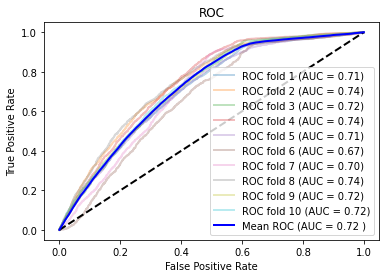

In [250]:
x  = input_n
y = target_n
for train,test in kfold.split(x,y):
    model = m_rfc.fit(x.iloc[train],y.iloc[train])
    pred_prob = model.predict_proba(x.iloc[test])
    pred = model.predict(x.iloc[test])

    #prediction = m_rfc.fit(x[train],y[train]).predict_proba(x[test])
    fpr, tpr, t = roc_curve(y.iloc[test], pred_prob[:, 1])
    recalls.append(recall_score(y.iloc[test], pred))
    precisions.append(precision_score(y.iloc[test], pred))
    f1scores.append(sklearn.metrics.f1_score(y.iloc[test], pred))
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = sklearn.metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = sklearn.metrics.auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [251]:
print(recalls)
print(np.mean(recalls))

[0.0013440860215053765, 0.0013440860215053765, 0.012992831541218637, 0.004032258064516129, 0.004032258064516129, 0.00985663082437276, 0.003585835948005379, 0.0031362007168458782, 0.0013440860215053765, 0.004032258064516129]
0.004570053128850717


In [252]:
print(precisions)
print(np.mean(precision))

[0.6, 0.5, 0.4393939393939394, 0.5625, 0.391304347826087, 0.08494208494208494, 0.2857142857142857, 0.4375, 1.0, 0.6428571428571429]
0.3157894736842105


In [253]:
print(f1scores)
print(np.mean(f1scores))

[0.002682163611980331, 0.002680965147453083, 0.025239338555265445, 0.008007117437722418, 0.007982261640798226, 0.017663588920112404, 0.007082779991146526, 0.006227758007117438, 0.0026845637583892616, 0.008014247551202136]
0.008826478462118727


In [254]:
print(aucs)
print(np.mean(aucs))

[0.708967663920288, 0.741957171689098, 0.7220917143798666, 0.7436553227695882, 0.706289573919195, 0.6689669213537749, 0.703765783244835, 0.7444817801672641, 0.7213686564829037, 0.724648485439576]
0.7186193073366389
